# FDA Recalls Data Preprocessing
**By Lorena Dorado & Parisa Kamizi**

- This notebook preprocesses the FDA recall data to create the final dataset for modeling

In [1]:
# Import Libraries
import re
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import us
import os

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

# Data Cleaning

In [2]:
# Load the data
file_path = '../data/recalls_details.xlsx'
df = pd.read_excel(file_path)

In [3]:
# Display basic information
print(f"Original data shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

Original data shape: (95082, 17)

Column names:
['FEI Number', 'Recalling Firm Name', 'Product Type', 'Product Classification', 'Status', 'Distribution Pattern', 'Recalling Firm City', 'Recalling Firm State', 'Recalling Firm Country', 'Center Classification Date', 'Reason for Recall', 'Product Description', 'Event ID', 'Event Classification', 'Product ID', 'Center', 'Recall Details']


Based on EDA, 2020 and onward showed decrease in recalls from 400-600 per month. Selecting years of stabilized volume of recalls.

In [4]:
# Convert 'Center Classification Date' to datetime
df['Center Classification Date'] = pd.to_datetime(df['Center Classification Date'], errors='coerce')

# Filter data from 2019 to present
df = df[df['Center Classification Date'].dt.year >= 2019]

# Display filtered data information
print(f"Data shape after filtering for 2019-2025: {df.shape}")
print(f"Date range: {df['Center Classification Date'].min()} to {df['Center Classification Date'].max()}")

Data shape after filtering for 2019-2025: (39366, 17)
Date range: 2019-01-03 00:00:00 to 2025-02-21 00:00:00


Dropping variables that are not predictive, redundant, and variables that introduce data leakeage

In [5]:
# Drop ID variables and features causing data leakage
drop_cols = [
    # ID variables (not predictive)
    "FEI Number", "Event ID", "Product ID", "Recall Details",
    # Features with data leakage
    "Product Classification",  # High correlation with target
    "Center",                  # One-to-one with Product Type
]
df = df.drop(columns=drop_cols)

In [6]:
# Display cleaned data information
print(f"Data shape after dropping ID columns: {df.shape}")

Data shape after dropping ID columns: (39366, 11)


In [7]:
# Handle missing values in Distribution Pattern
df['Distribution Pattern'] = df['Distribution Pattern'].fillna('Unknown')

In [8]:
# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Recalling Firm Name           0
Product Type                  0
Status                        0
Distribution Pattern          0
Recalling Firm City           0
Recalling Firm State          0
Recalling Firm Country        0
Center Classification Date    0
Reason for Recall             0
Product Description           0
Event Classification          0
dtype: int64


# Data Preparation and Train-Test Split

In [9]:
# Define target variable
X = df.drop(columns=['Event Classification'])
y = df['Event Classification']

In [10]:
# Create a stratified train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set class distribution: {y_train.value_counts(normalize=True)}")
print(f"Test set class distribution: {y_test.value_counts(normalize=True)}")

Training set shape: (31492, 10)
Test set shape: (7874, 10)

Training set class distribution: Event Classification
Class II     0.718246
Class I      0.212244
Class III    0.069510
Name: proportion, dtype: float64
Test set class distribution: Event Classification
Class II     0.718186
Class I      0.212217
Class III    0.069596
Name: proportion, dtype: float64


## Feature Engineering on Training and Test Data

In [11]:
# Initialize processed DataFrames
X_train_processed = pd.DataFrame(index=X_train.index)
X_test_processed = pd.DataFrame(index=X_test.index)

#### Processing temporal features: Feature engineering for 'Center Classification Date'

In [12]:
# Convert to datetime
X_train['temp_date'] = pd.to_datetime(X_train['Center Classification Date'], errors='coerce')
X_test['temp_date'] = pd.to_datetime(X_test['Center Classification Date'], errors='coerce')

# Extract temporal features
X_train_processed['Classification_Year'] = X_train['temp_date'].dt.year
X_train_processed['Classification_Month'] = X_train['temp_date'].dt.month
X_train_processed['Classification_DayOfWeek'] = X_train['temp_date'].dt.dayofweek

X_test_processed['Classification_Year'] = X_test['temp_date'].dt.year
X_test_processed['Classification_Month'] = X_test['temp_date'].dt.month
X_test_processed['Classification_DayOfWeek'] = X_test['temp_date'].dt.dayofweek

In [13]:
# Add cyclical encoding for month and day of week
X_train_processed['Month_sin'] = np.sin(2 * np.pi * X_train_processed['Classification_Month']/12)
X_train_processed['Month_cos'] = np.cos(2 * np.pi * X_train_processed['Classification_Month']/12)
X_train_processed['DayOfWeek_sin'] = np.sin(2 * np.pi * X_train_processed['Classification_DayOfWeek']/7)
X_train_processed['DayOfWeek_cos'] = np.cos(2 * np.pi * X_train_processed['Classification_DayOfWeek']/7)

X_test_processed['Month_sin'] = np.sin(2 * np.pi * X_test_processed['Classification_Month']/12)
X_test_processed['Month_cos'] = np.cos(2 * np.pi * X_test_processed['Classification_Month']/12)
X_test_processed['DayOfWeek_sin'] = np.sin(2 * np.pi * X_test_processed['Classification_DayOfWeek']/7)
X_test_processed['DayOfWeek_cos'] = np.cos(2 * np.pi * X_test_processed['Classification_DayOfWeek']/7)

In [14]:
# Normalize year to avoid scale issues
min_year = min(X_train_processed['Classification_Year'].min(), 
              X_test_processed['Classification_Year'].min())
X_train_processed['Years_Since_First'] = X_train_processed['Classification_Year'] - min_year
X_test_processed['Years_Since_First'] = X_test_processed['Classification_Year'] - min_year

In [15]:
# Drop intermediate temporal features after transformation
X_train_processed = X_train_processed.drop(columns=['Classification_Year', 'Classification_Month', 'Classification_DayOfWeek'])
X_test_processed = X_test_processed.drop(columns=['Classification_Year', 'Classification_Month', 'Classification_DayOfWeek'])

#### Processing categorical features

Product Type as strong predictor based on chi-square test

In [16]:
# Process Product Type
encoder = OneHotEncoder(sparse_output=False, drop='first')
product_type_train = encoder.fit_transform(X_train[['Product Type']])
product_type_test = encoder.transform(X_test[['Product Type']])

In [17]:
# Assign feature names
product_type_cols = [f'ProductType_{cat}' for cat in encoder.categories_[0][1:]]
X_train_processed[product_type_cols] = product_type_train
X_test_processed[product_type_cols] = product_type_test

In [18]:
# Process Status
encoder = OneHotEncoder(sparse_output=False, drop='first')
status_train = encoder.fit_transform(X_train[['Status']])
status_test = encoder.transform(X_test[['Status']])

In [19]:
# Assign feature names
status_cols = [f'Status_{cat}' for cat in encoder.categories_[0][1:]]
X_train_processed[status_cols] = status_train
X_test_processed[status_cols] = status_test

#### Feature engineering for 'Recalling Firm Country'

In [20]:
# Create binary US indicator
X_train_processed['Is_US'] = (X_train['Recalling Firm Country'] == 'United States').astype(int)
X_test_processed['Is_US'] = (X_test['Recalling Firm Country'] == 'United States').astype(int)

In [21]:
# Create Is_US in for region mapping
X_train['Is_US'] = (X_train['Recalling Firm Country'] == 'United States').astype(int)
X_test['Is_US'] = (X_test['Recalling Firm Country'] == 'United States').astype(int)

In [22]:
# List of states & territories to include
included_states = {
    'AZ', 'PA', 'CA', 'MN', 'AR', 'IN', 'NJ', 'KS', 'TN', 'WI', 'NY', 'NC', 'RI', 'WA',
    'IL', 'MT', 'CO', 'TX', 'MA', 'OR', 'FL', 'GA', 'MI', 'AL', 'MO', 'IA', 'UT', 'PR',
    'SC', 'LA', 'VA', 'OK', 'DE', 'NH', 'CT', 'ID', 'MD', 'OH', 'ND', 'NE', 'HI', 'KY',
    'WV', 'SD', 'ME', 'AK', 'NM', 'MS', 'NV', 'VT', 'WY', 'DC', 'GU'
}

# Region mapping for list
state_region_map = {
    # Northeast
    'ME': 'Northeast', 'NH': 'Northeast', 'VT': 'Northeast', 'MA': 'Northeast',
    'RI': 'Northeast', 'CT': 'Northeast', 'NY': 'Northeast', 'NJ': 'Northeast', 'PA': 'Northeast',

    # Midwest
    'OH': 'Midwest', 'MI': 'Midwest', 'IN': 'Midwest', 'WI': 'Midwest', 'IL': 'Midwest',
    'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 'ND': 'Midwest', 'SD': 'Midwest',
    'NE': 'Midwest', 'KS': 'Midwest',

    # South
    'DE': 'South', 'MD': 'South', 'VA': 'South', 'WV': 'South', 'KY': 'South', 'NC': 'South',
    'SC': 'South', 'TN': 'South', 'GA': 'South', 'FL': 'South', 'AL': 'South', 'MS': 'South',
    'AR': 'South', 'LA': 'South', 'TX': 'South', 'OK': 'South', 'DC': 'South', 'PR': 'South',

    # West
    'MT': 'West', 'ID': 'West', 'WY': 'West', 'CO': 'West', 'NM': 'West', 'AZ': 'West',
    'UT': 'West', 'NV': 'West', 'CA': 'West', 'OR': 'West', 'WA': 'West', 'AK': 'West', 'HI': 'West',

    # Pacific Territories
    'GU': 'Territory'
}

In [23]:
# Used ChatGPT to create this function that maps US states to a region
def map_region(state):
    if not isinstance(state, str):
        return 'Unknown'

    normalized = us.states.lookup(state)

    if not normalized or normalized.abbr not in included_states:
        return 'Excluded'

    return state_region_map.get(normalized.abbr, 'International')

In [24]:
# Apply region mapping to US states
X_train['Region'] = X_train.apply(
    lambda x: map_region(x['Recalling Firm State']) if x['Is_US'] == 1 else 'International', 
    axis=1
)
X_test['Region'] = X_test.apply(
    lambda x: map_region(x['Recalling Firm State']) if x['Is_US'] == 1 else 'International', 
    axis=1
)

In [25]:
# Create region dummies
encoder = OneHotEncoder(sparse_output=False, drop='first')
region_train = encoder.fit_transform(X_train[['Region']])
region_test = encoder.transform(X_test[['Region']])

In [26]:
# Assign feature names
region_cols = [f'Region_{cat}' for cat in encoder.categories_[0][1:]]
X_train_processed[region_cols] = region_train
X_test_processed[region_cols] = region_test

In [27]:
# Drop intermediate Is_US column
X_train = X_train.drop(columns=['Is_US'])
X_test = X_test.drop(columns=['Is_US']) 
X_train_processed = X_train_processed.drop(columns=['Is_US'])
X_test_processed = X_test_processed.drop(columns=['Is_US'])

#### Feature engineering for 'Distribution Pattern'

In [28]:
# Simplify Distribution Pattern into categories
def categorize_distribution(pattern):
    if not isinstance(pattern, str):
        return 'Unknown'
    
    pattern = pattern.lower()
    
    if any(term in pattern for term in ['nationwide', 'national', 'across us', 'throughout us']):
        return 'Nationwide'
    elif any(term in pattern for term in ['worldwide', 'international', 'global', 'exported']):
        return 'International'
    elif any(term in pattern for term in ['regional', 'multi-state', 'states', 'multiple states']):
        return 'Regional'
    elif any(term in pattern for term in ['limited', 'local', 'single']):
        return 'Limited'
    else:
        return 'Other'

In [29]:
# Apply distribution pattern categorization
X_train['Distribution_Scope'] = X_train['Distribution Pattern'].apply(categorize_distribution)
X_test['Distribution_Scope'] = X_test['Distribution Pattern'].apply(categorize_distribution)

In [30]:
# Create distribution scope dummies
encoder = OneHotEncoder(sparse_output=False, drop='first')
dist_train = encoder.fit_transform(X_train[['Distribution_Scope']])
dist_test = encoder.transform(X_test[['Distribution_Scope']])

In [31]:
# Get feature names
dist_cols = [f'DistScope_{cat}' for cat in encoder.categories_[0][1:]]
X_train_processed[dist_cols] = dist_train
X_test_processed[dist_cols] = dist_test

#### Processing text features: Clean and Normalize Text Data

In [32]:
# Define text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase 
    text = str(text).lower()
    
    # Normalize pathogen names
    text = re.sub(r'listeria\s+monocytogenes', 'listeria_monocytogenes', text)
    text = re.sub(r'escherichia\s+coli', 'ecoli', text)
    text = re.sub(r'e\.?\s*coli', 'ecoli', text)
    text = re.sub(r'salmonella\s+\w+', 'salmonella', text)
    
    # Normalize allergen references
    text = re.sub(r'undeclared\s+(milk|soy|wheat|egg|peanut|tree\s+nut|fish|shellfish)', 
                 r'undeclared_allergen_\1', text)
    
    # Normalize manufacturing issues
    text = re.sub(r'(manufacturing|production)\s+(defect|error|issue|problem)', 
                 'manufacturing_defect', text)
    
    # Remove special characters but preserve normalized terms
    text = re.sub(r'[^\w\s_]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    fda_stopwords = {'recalled', 'recalling', 'firm', 'product', 'products', 'recall', 
                     'various', 'due', 'manufactured'}
    all_stopwords = stop_words.union(fda_stopwords)
    
    tokens = text.split()
    filtered_tokens = [w for w in tokens if w not in all_stopwords]
    
    return ' '.join(filtered_tokens)

In [33]:
# Apply text cleaning
X_train['reason_cleaned'] = X_train['Reason for Recall'].apply(clean_text)
X_test['reason_cleaned'] = X_test['Reason for Recall'].apply(clean_text)

In [34]:
# Create word count features
X_train_processed['Reason_Word_Count'] = X_train['Reason for Recall'].apply(
    lambda x: len(str(x).split()))
X_test_processed['Reason_Word_Count'] = X_test['Reason for Recall'].apply(
    lambda x: len(str(x).split()))

In [35]:
# Used ChatGPT to create this function to xtract specific recall indicators
def extract_recall_flags(reason_text):
    flags = {}
    reason = str(reason_text).lower() if isinstance(reason_text, str) else ""
    
    # Pathogens
    flags['has_listeria'] = 1 if re.search(r'listeria|monocytogenes', reason) else 0
    flags['has_salmonella'] = 1 if 'salmonella' in reason else 0
    flags['has_ecoli'] = 1 if re.search(r'e\.?\s*coli|escherichia', reason) else 0
    
    # Allergens
    flags['has_undeclared'] = 1 if 'undeclared' in reason else 0
    flags['has_allergen'] = 1 if re.search(r'allergen|allergic|allergy', reason) else 0
    for allergen in ['milk', 'soy', 'wheat', 'egg', 'peanut', 'nut', 'fish', 'shellfish']:
        flags[f'allergen_{allergen}'] = 1 if allergen in reason else 0
    
    # Manufacturing issues
    flags['has_manufacturing_issue'] = 1 if re.search(r'manufactur|production|process', reason) else 0
    flags['has_quality_issue'] = 1 if re.search(r'quality|control|inspection', reason) else 0
    flags['has_mislabeling'] = 1 if re.search(r'mislabel|incorrect label|wrong label', reason) else 0
    
    # Foreign material
    flags['has_foreign_material'] = 1 if re.search(r'foreign|material|particulate|metal|glass|plastic', reason) else 0
    
    # Risk indicators
    flags['possible_illness'] = 1 if re.search(r'illness|disease|sick|adverse', reason) else 0
    flags['possible_injury'] = 1 if re.search(r'injur|harm|wound', reason) else 0
    
    return flags

In [36]:
# Apply flag extraction
train_flags = X_train['Reason for Recall'].apply(extract_recall_flags)
test_flags = X_test['Reason for Recall'].apply(extract_recall_flags)

In [37]:
# Convert flags to DataFrame
train_flags_df = pd.DataFrame.from_records(train_flags.tolist(), index=X_train.index)
test_flags_df = pd.DataFrame.from_records(test_flags.tolist(), index=X_test.index)

In [38]:
# Add flags to processed DataFrames
X_train_processed = pd.concat([X_train_processed, train_flags_df], axis=1)
X_test_processed = pd.concat([X_test_processed, test_flags_df], axis=1)

In [39]:
# Save a copy of the processed data without SVD features as baseline
X_train_baseline = X_train_processed.copy()
X_test_baseline = X_test_processed.copy()

Apply TF-IDF vectorization

In [40]:
# # Used ChatGPT to obtain structure for parameters
# TF-IDF Vectorization with n-grams
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Limit top 1000 features
    min_df=5,           # Ignore terms that appear in fewer than 5 documents
    max_df=0.7,         # Ignore terms that appear in more than 70% of documents
    ngram_range=(1, 2), # Include unigrams and bigrams
    use_idf=True,
    sublinear_tf=True   # Apply sublinear tf scaling (1 + log(tf))
)

In [41]:
# Fit and transform on training data
tfidf_matrix_train = tfidf_vectorizer.fit_transform(X_train['reason_cleaned'])
tfidf_matrix_test = tfidf_vectorizer.transform(X_test['reason_cleaned'])

In [42]:
# Apply dimensionality reduction
n_components = 100  # Reduce to 100 components as recommended
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_svd_train = svd.fit_transform(tfidf_matrix_train)
tfidf_svd_test = svd.transform(tfidf_matrix_test)

In [43]:
# Calculate explained variance
explained_var = svd.explained_variance_ratio_.sum()
print(f"Explained variance from {n_components} SVD components: {explained_var:.2f}")

Explained variance from 100 SVD components: 0.54


At least half of the original variance in the data was retained after dimensionality reduction.

At least half of the original variance in the data was retained after dimensionality reduction.

Store transformed text data into columns

In [44]:
# Create text feature DataFrames
text_cols = [f'text_svd_{i}' for i in range(n_components)]
train_text_df = pd.DataFrame(tfidf_svd_train, columns=text_cols, index=X_train.index)
test_text_df = pd.DataFrame(tfidf_svd_test, columns=text_cols, index=X_test.index)

Processed text features in hybrid datasets only

In [45]:
# Add text SVD features to processed DataFrames to create hybrid datasets
X_train_hybrid = pd.concat([X_train_processed, train_text_df], axis=1)
X_test_hybrid = pd.concat([X_test_processed, test_text_df], axis=1)

Understanding which words are strongly associated with a particular SVD topic/component.

In [46]:
# Function to interpret SVD components
def interpret_svd_component(svd_model, vectorizer, component_idx, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    component = svd_model.components_[component_idx]
    sorted_terms = sorted(zip(terms, component), key=lambda x: x[1], reverse=True)
    return sorted_terms[:n_terms]

In [47]:
# Display interpretation of top 5 SVD components
print("\nTop terms in first 5 SVD components:")
for i in range(5):
    top_terms = interpret_svd_component(svd, tfidf_vectorizer, i)
    print(f"SVD Component {i}:")
    print(", ".join([f"{term} ({weight:.4f})" for term, weight in top_terms]))
    print()


Top terms in first 5 SVD components:
SVD Component 0:
lack (0.4566), assurance (0.4548), sterility (0.4495), assurance sterility (0.4211), lack assurance (0.4206), sterility assurance (0.0932), lack sterility (0.0903), fda inspection (0.0319), sterility fda (0.0314), inspection (0.0295)

SVD Component 1:
cgmp (0.4108), deviations (0.3873), cgmp deviations (0.3799), potential (0.2965), listeria_monocytogenes (0.2594), contamination (0.2567), contaminated (0.2297), contaminated listeria_monocytogenes (0.1794), may (0.1560), salmonella (0.1453)

SVD Component 2:
cgmp (0.4103), deviations (0.3850), cgmp deviations (0.3798), impurity (0.0611), temperature (0.0541), storage (0.0392), stability (0.0360), outside (0.0328), temperature abuse (0.0326), abuse (0.0325)

SVD Component 3:
distributed (0.4190), blood (0.3681), donor (0.2479), collected (0.1977), may (0.1952), blood collected (0.1561), collected donor (0.1529), red (0.1377), red blood (0.1345), _x000d_ (0.1130)

SVD Component 4:
cont

These five SVD components capture distinct safety-related topics from the text data. 
- Component 0: problems with cleanliness and product safety.
- Component 1: manufacturing issues and contamination from harmful bacteria like Listeria and Salmonella.
- Component 2: manufacturing problems with concerns about storage conditions and impurities.
- Component 3: focuses on blood collection and distribution.
- Component 4: focuses on contamination by microbes, blood, and Salmonella.

## Create pre-processed TRAINING dataset for modeling

In [48]:
# Verify datasets have matching columns
print(f"Baseline training set shape: {X_train_baseline.shape}")
print(f"Baseline test set shape: {X_test_baseline.shape}")
print(f"Hybrid training set shape: {X_train_hybrid.shape}")
print(f"Hybrid test set shape: {X_test_hybrid.shape}")

Baseline training set shape: (31492, 41)
Baseline test set shape: (7874, 41)
Hybrid training set shape: (31492, 141)
Hybrid test set shape: (7874, 141)


#### Create BASELINE datasets (without text SVD features)

In [49]:
# Add the target variable to the baseline training dataset
train_baseline = X_train_baseline.copy()
train_baseline['Event Classification'] = y_train.values

In [50]:
# Add the target variable to the baseline test dataset
test_baseline = X_test_baseline.copy()
test_baseline['Event Classification'] = y_test.values

In [51]:
print(f"Baseline Training set shape: {train_baseline.shape}")
print(f"Baseline Test set shape: {test_baseline.shape}")
print("\nBaseline Column count:")
print(f"{len(test_baseline.columns)} columns")
print("\n Baseline Column names:")
print(test_baseline.columns.tolist())

Baseline Training set shape: (31492, 42)
Baseline Test set shape: (7874, 42)

Baseline Column count:
42 columns

 Baseline Column names:
['Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Years_Since_First', 'ProductType_Devices', 'ProductType_Drugs', 'ProductType_Food/Cosmetics', 'ProductType_Tobacco', 'ProductType_Veterinary', 'Status_Ongoing', 'Status_Terminated', 'Region_International', 'Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_West', 'DistScope_Limited', 'DistScope_Nationwide', 'DistScope_Other', 'DistScope_Regional', 'Reason_Word_Count', 'has_listeria', 'has_salmonella', 'has_ecoli', 'has_undeclared', 'has_allergen', 'allergen_milk', 'allergen_soy', 'allergen_wheat', 'allergen_egg', 'allergen_peanut', 'allergen_nut', 'allergen_fish', 'allergen_shellfish', 'has_manufacturing_issue', 'has_quality_issue', 'has_mislabeling', 'has_foreign_material', 'possible_illness', 'possible_injury', 'Event Classification']


#### Create HYBRID datasets (with text SVD features)

In [52]:
# Add the target variable to the hybrid training dataset
train_hybrid = X_train_hybrid.copy()
train_hybrid['Event Classification'] = y_train.values

In [53]:
# Add the target variable to the hybrid test dataset
test_hybrid = X_test_hybrid.copy()
test_hybrid['Event Classification'] = y_test.values

In [54]:
print(f"Hybrid Training set shape: {train_hybrid.shape}")
print(f"Hybrid Test set shape: {test_hybrid.shape}")
print("\nHybrid Column count:")
print(f"{len(test_hybrid.columns)} columns")
print("\n Hybrid Column names:")
print(test_hybrid.columns.tolist())

Hybrid Training set shape: (31492, 142)
Hybrid Test set shape: (7874, 142)

Hybrid Column count:
142 columns

 Hybrid Column names:
['Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Years_Since_First', 'ProductType_Devices', 'ProductType_Drugs', 'ProductType_Food/Cosmetics', 'ProductType_Tobacco', 'ProductType_Veterinary', 'Status_Ongoing', 'Status_Terminated', 'Region_International', 'Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_West', 'DistScope_Limited', 'DistScope_Nationwide', 'DistScope_Other', 'DistScope_Regional', 'Reason_Word_Count', 'has_listeria', 'has_salmonella', 'has_ecoli', 'has_undeclared', 'has_allergen', 'allergen_milk', 'allergen_soy', 'allergen_wheat', 'allergen_egg', 'allergen_peanut', 'allergen_nut', 'allergen_fish', 'allergen_shellfish', 'has_manufacturing_issue', 'has_quality_issue', 'has_mislabeling', 'has_foreign_material', 'possible_illness', 'possible_injury', 'text_svd_0', 'text_svd_1', 'text_svd_2', 'text_svd_3', 'text_svd_4', 't

Save the processed datasets

In [55]:
# Baseline datasets
train_baseline.to_csv('../data/train_baseline.csv', index=False)
test_baseline.to_csv('../data/test_baseline.csv', index=False)

# Hybrid datasets
train_hybrid.to_csv('../data/train_hybrid.csv', index=False)
test_hybrid.to_csv('../data/test_hybrid.csv', index=False)

## Correlation Matrix of Selected Features with Target

In [56]:
# Use baseline dataset
corr_baseline = train_baseline.copy()

In [57]:
# Encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
corr_baseline['Event_Classification_Encoded'] = le.fit_transform(corr_baseline['Event Classification'])

In [58]:
# Select features
selected_features = [
    # Pathogen indicators
    'has_listeria', 'has_salmonella', 'has_ecoli',
    
    # Allergen indicators
    'has_allergen', 'allergen_peanut', 'allergen_nut', 'allergen_shellfish',
    'allergen_fish', 'allergen_milk', 'allergen_egg', 'allergen_wheat', 'allergen_soy',
    
    # Manufacturing issues
    'has_manufacturing_issue', 'has_quality_issue', 'has_mislabeling',
    'has_foreign_material',
    
    # Risk indicators
    'possible_illness', 'possible_injury',
    
    # Product types
    'ProductType_Devices', 'ProductType_Drugs', 'ProductType_Food/Cosmetics', 'ProductType_Veterinary',
    
    # Distribution scope
    'DistScope_Nationwide', 'DistScope_Regional', 'DistScope_Limited',
    
    # Recall word count
    'Reason_Word_Count'
]

In [59]:
# Create correlation matrix
features_with_target = selected_features + ['Event_Classification_Encoded']
corr_matrix = corr_baseline[features_with_target].corr()

In [60]:
# Create directory if it doesn't exist
os.makedirs('../image_folder', exist_ok=True)

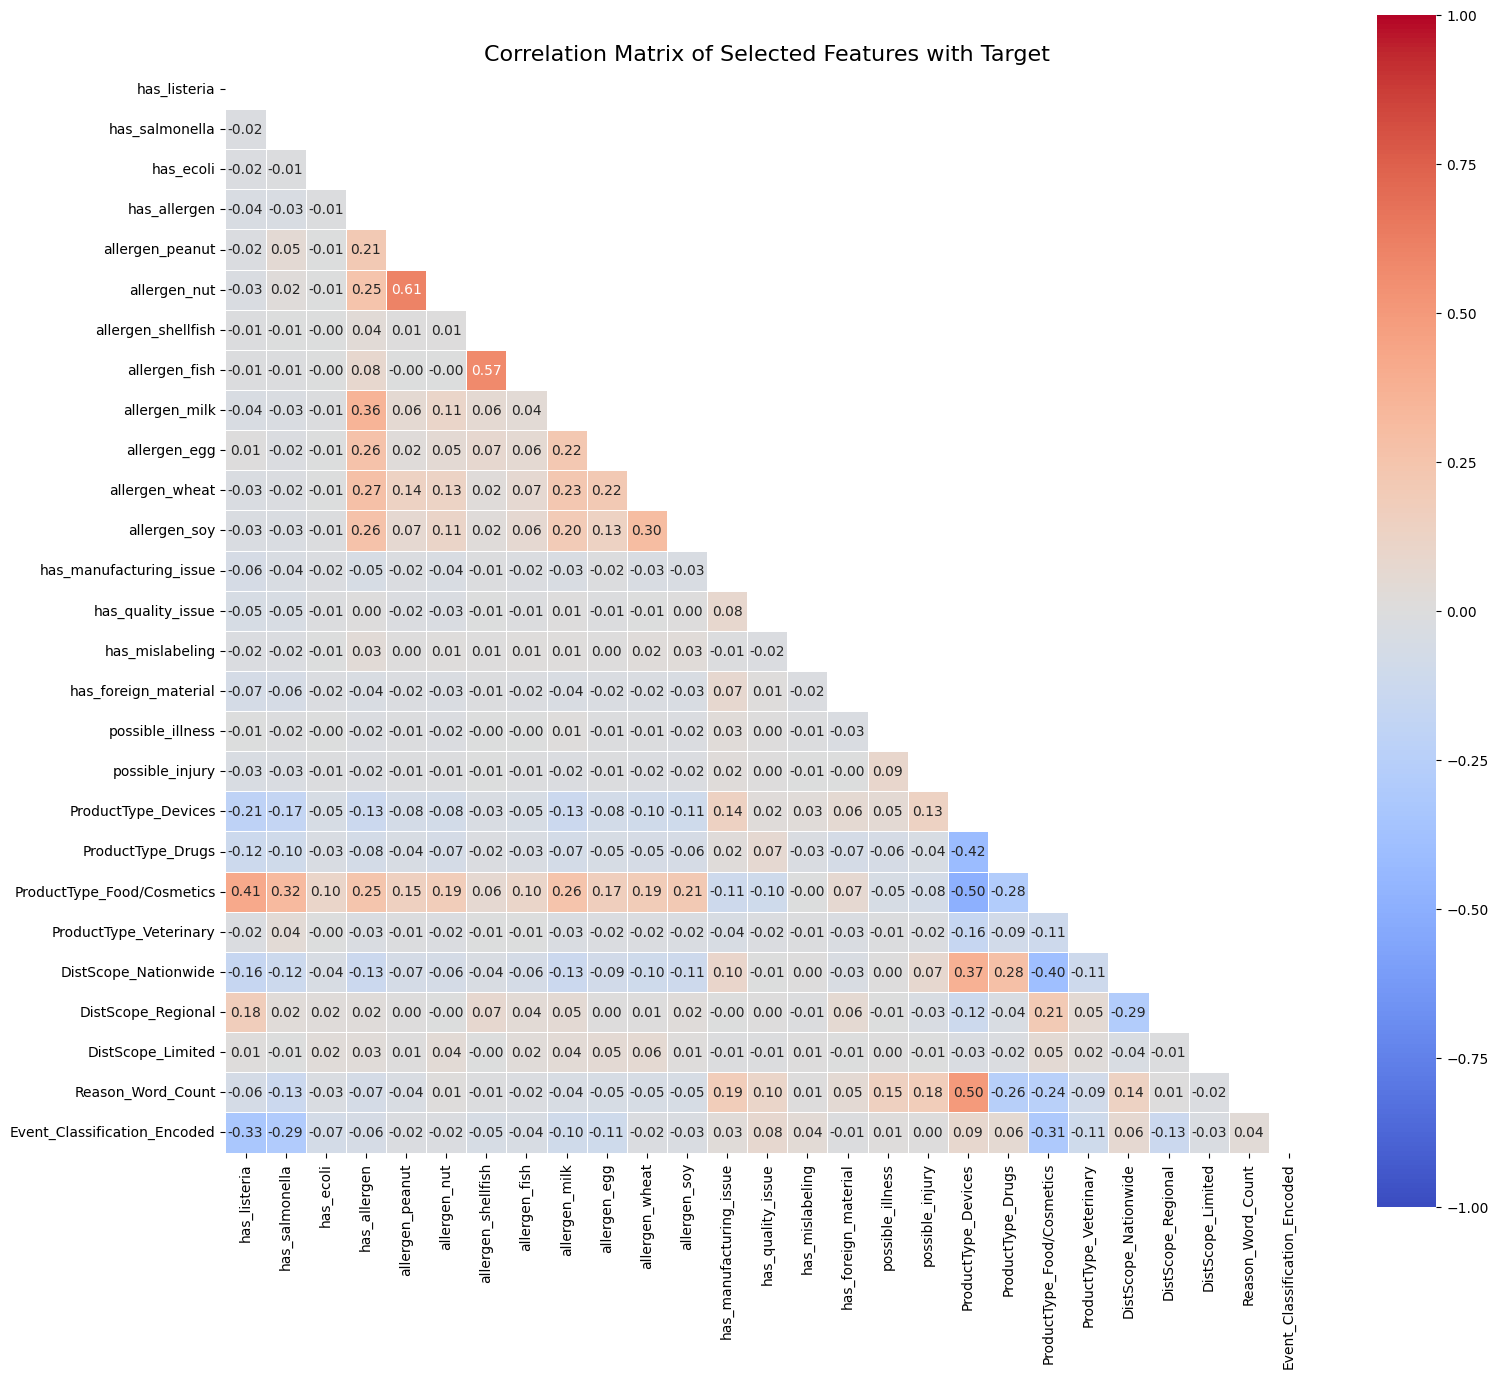

In [61]:
# Plot correlation matrix
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, 
           center=0, annot=True, fmt='.2f', square=True, linewidths=.5)
plt.title('Correlation Matrix of Selected Features with Target', fontsize=16)
plt.tight_layout()
plt.savefig('../image_folder/feature_correlation_matrix.png', dpi=300)
plt.show()

In [62]:
# Display correlations with target
target_correlations = corr_matrix['Event_Classification_Encoded'].drop('Event_Classification_Encoded')
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

Top Feature Correlations with Recall Severity:

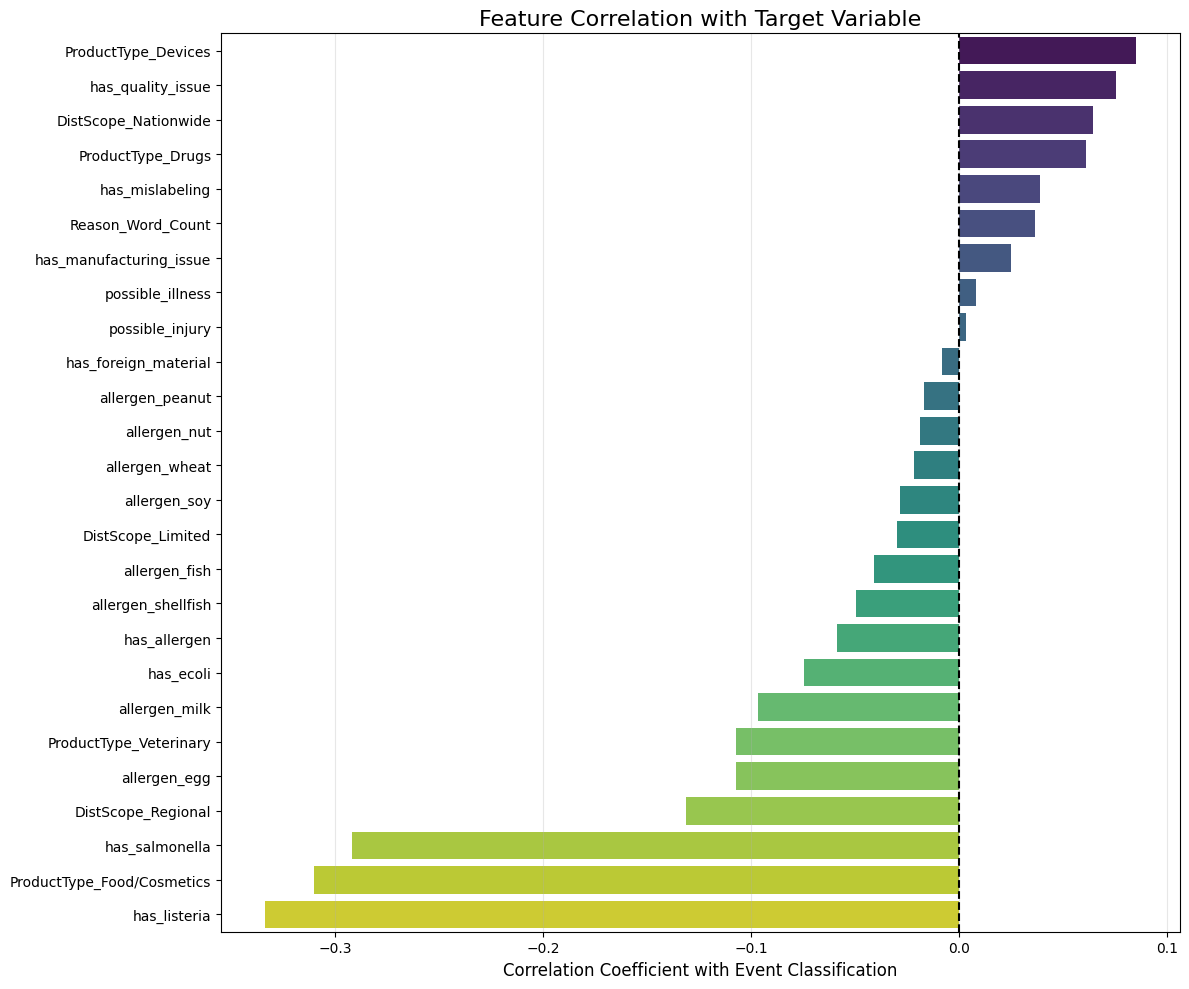

In [63]:
# Plot correlation with target specifically
target_corr = corr_matrix['Event_Classification_Encoded'].drop('Event_Classification_Encoded')
target_corr = target_corr.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(
    x=target_corr.values,
    y=target_corr.index,
    hue=target_corr.index,
    palette='viridis',
    dodge=False,
    legend=False  # hide the hue legend
)
plt.title('Feature Correlation with Target Variable', fontsize=16)
plt.xlabel('Correlation Coefficient with Event Classification', fontsize=12)
plt.ylabel('')
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../image_folder/target_correlation.png', dpi=300)
plt.show()